In [1]:
# add ../src directory to path
import sys
sys.path.append('../src')

# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import gpytorch
import torch
import pandas as pd
import importlib

# reimport GPGridSearch and utils
import GPGridSearch
import utils
importlib.reload(GPGridSearch)
importlib.reload(utils)
from GPGridSearch import GPGridSearch
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data and inject an anomaly

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:202: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


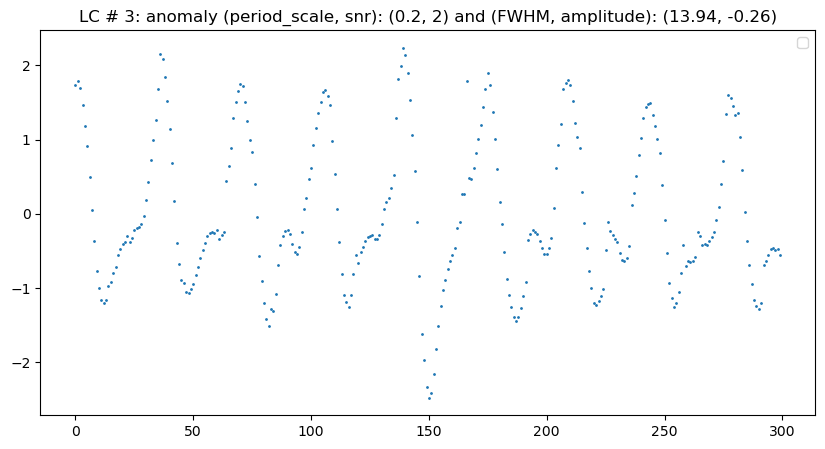

Anomaly locations:
[1367]


In [9]:
# TODO: explore this further

# Data and anomaly parameters
file_number = 3
shape = "gaussian"
period_scale = 0.2
snr = 2
loc = 1367

# Load the data
data_dir = '../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Inject anomalies
steps, y, anomaly_locs, anomaly_amp, anomaly_fwhm = inject_anomaly(
    y, 
    num_anomalies=1, 
    seed=file_number, 
    shapes=[shape],
    period_scale=period_scale,
    snr=snr,
    anomaly_idx=[loc]
)

# Narrow in to boundary right +500 and -500 inidices from loc, and sparisfy by 10
steps = np.array(range(len(x)))
mask = np.logical_and(steps > loc - 300, steps < loc + 300)
x = x[mask][::2]
y = y[mask][::2]
y_err = y_err[mask][::2]

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
# for i in range(len(anomaly_locs)):
#     plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5, label='Anomaly center')
plt.legend()
plt.title(f"LC # {file_number}: anomaly (period_scale, snr): ({period_scale}, {snr}) and (FWHM, amplitude): ({anomaly_fwhm:.2f}, {anomaly_amp:.2f})")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
# for i in anomaly_locs: print(x[int(i)])

# Perform grid search to find most anomalous interval

In [10]:
# Check anomalous intervals are assigned correctly
num_steps = len(x)

# Set constraints for anomaly length
min_anomaly_len = int(1 / (2 * np.median(np.diff(x))))  # Nyquist frequency
max_anomaly_len = int(0.1 * num_steps)  # Max 10% of total steps

# Possible anomaly intervals
anomaly_intervals = [(i, j) for i in range(num_steps)
                            for j in range(i + min_anomaly_len, min(i + max_anomaly_len, num_steps))]

print("Number of steps:", num_steps, "min anomaly length:", min_anomaly_len, "max anomaly length:", max_anomaly_len)
print("Number of anomaly intervals:", len(anomaly_intervals))
print("First 10 anomaly intervals:", anomaly_intervals[:10])

Number of steps: 300 min anomaly length: 11 max anomaly length: 30
Number of anomaly intervals: 5320
First 10 anomaly intervals: [(0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20)]


In [11]:
# Hyperparameters
which_metric = 'mll'
initial_lengthscale = 0.5
training_iterations = 50
filename = f'../results/test.txt'

gp_detector = GPGridSearch(
    x,
    y,
    y_err,
    which_metric=which_metric,
    initial_lengthscale=initial_lengthscale,
)

best_interval, max_metric = gp_detector.find_anomalous_interval(device=device, training_iterations=training_iterations, filename=filename)

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Anomaly interval: 0-11, Metric: -0.8232322335243225


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Anomaly interval: 0-12, Metric: -0.8233791589736938
Anomaly interval: 0-13, Metric: -0.8234961628913879
Anomaly interval: 0-14, Metric: -0.8234027028083801
Anomaly interval: 0-15, Metric: -0.8235155940055847
Anomaly interval: 0-16, Metric: -0.8235975503921509
Anomaly interval: 0-17, Metric: -0.8236908316612244
Anomaly interval: 0-18, Metric: -0.8237404823303223
Anomaly interval: 0-19, Metric: -0.8238286375999451
Anomaly interval: 0-20, Metric: -0.823889970779419
Anomaly interval: 0-21, Metric: -0.8239285349845886
Anomaly interval: 0-22, Metric: -0.8239251971244812
Anomaly interval: 0-23, Metric: -0.8240162134170532
Anomaly interval: 0-24, Metric: -0.8240134716033936
Anomaly interval: 0-25, Metric: -0.8238646388053894
Anomaly interval: 0-26, Metric: -0.8239243626594543
Anomaly interval: 0-27, Metric: -0.8240159749984741
Anomaly interval: 0-28, Metric: -0.8241263031959534
Anomaly interval: 0-29, Metric: -0.8242369294166565
Anomaly interval: 1-12, Metric: -0.8257683515548706
Anomaly inter

### Analyze

   start  end    metric
0      0   11 -0.823232
1      0   12 -0.823379
2      0   13 -0.823496
3      0   14 -0.823403
4      0   15 -0.823516
Best intervaL:       start  end    metric
2766    145  167 -0.817212


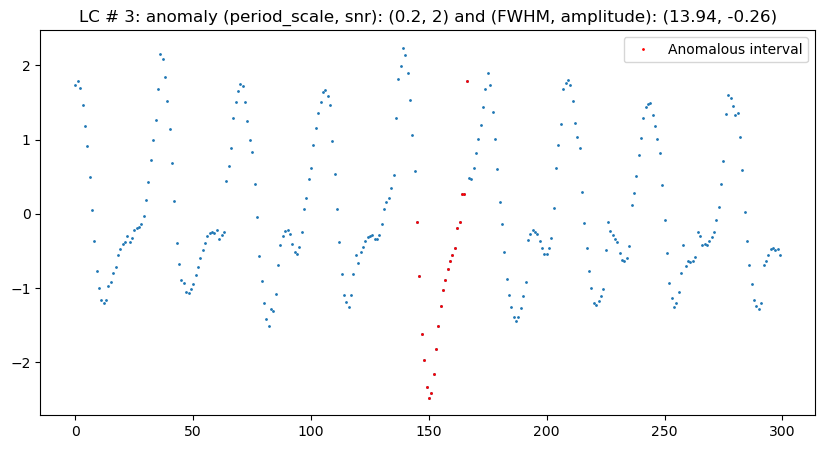

In [14]:
# results are stored in a txt file, with header: start,end,metric
data = pd.read_csv(filename, header=0, sep=",")
print(data.head())

# find the best metric start and end interval
best_metric = data["metric"].max()
best_interval = data[data["metric"] == best_metric]
start = int(best_interval["start"].values[0])
end = int(best_interval["end"].values[0])
print(f"Best intervaL: {best_interval}")

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
plt.plot(range(start, end), y[start:end], '.', color='r', markersize=2, label='Anomalous interval')
plt.legend()
plt.title(f"LC # {file_number}: anomaly (period_scale, snr): ({period_scale}, {snr}) and (FWHM, amplitude): ({anomaly_fwhm:.2f}, {anomaly_amp:.2f})")
plt.show()

In [13]:
# Print the metric for the range with the center of the anomaly in the middle
print("Metric for the range overlapping the anomaly center:")
anomaly_overlap = data[(data["start"] <= loc) & (data["end"] >= loc)]
best_anomaly_metric = anomaly_overlap["metric"].max()
best_anomaly_interval = anomaly_overlap[anomaly_overlap["metric"] == best_anomaly_metric]
print(best_anomaly_interval)

Metric for the range overlapping the anomaly center:
Empty DataFrame
Columns: [start, end, metric]
Index: []
